###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):**     `1255109, 1214260`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [ ]:
#import libraries

import pandas as pd
import math
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
def numeric_columns(data):
  ''' Get the list of numeric features from the data
  '''
  numeric_col = data.select_dtypes(include='number').columns
  return numeric_col

In [ ]:
def preprocess(fname):
  ''' Prepare the data by reading it from a file and converting it into 
  a useful format for training and testing
  '''
  # read data from a file
  data = pd.read_csv(fname)

  # get the list of numeric features for standardization
  numeric_col = numeric_columns(data)

  # standardise all columns
  scaler = StandardScaler() 

  # Fit and transform the training and test data using the scaler
  data[numeric_col] = scaler.fit_transform(data[numeric_col])

  return data

# Load datasets, put your own file paths to read the dataset
gz_test = preprocess('/content/drive/MyDrive/COMP30027_asst1/COMP30027_2023_asst1_data/gztan_test.csv')
gz_train = preprocess('/content/drive/MyDrive/COMP30027_asst1/COMP30027_2023_asst1_data/gztan_train.csv')
pc_test = preprocess('/content/drive/MyDrive/COMP30027_asst1/COMP30027_2023_asst1_data/pop_vs_classical_test.csv')
pc_train = preprocess('/content/drive/MyDrive/COMP30027_asst1/COMP30027_2023_asst1_data/pop_vs_classical_train.csv')

In [ ]:
def calc_pdf(x, mean, std):
  ''' Calculate the Gaussian pdf
  x: an instance
  mean: mean value for the feature
  std: standard deviation for the feature
  '''
  exponent = math.exp(-((x - mean) ** 2 / (2 * std ** 2)))
  return (1 / (math.sqrt(2 * math.pi) * std)) * exponent

In [ ]:
def calc_prior(data):
  ''' Calculate prior probability with the data
  The following block of code taken from COMP30027 Workshop 2
  '''
  prior_prob = {}

  labels = data['label']
  n = len(labels)
  unique_labels, counts = np.unique(labels, return_counts=True)

  for i in range(len(unique_labels)):
    prior_prob[unique_labels[i]] = (counts[i] / n)

  return prior_prob

In [ ]:
def calc_statistics(data):
  ''' Calculate the mean and standard deviation of the features for training set
  '''

  # Create an empty dictionary to store the mean and standard deviation of each feature
  statistics = {}

  unique_labels = np.unique(data['label'])
  features_list = numeric_columns(data)
    
  for feature in features_list:
    # Create a nested dictionary for each feature
    statistics[feature] = {}

    for label in unique_labels:
      label_data = data[data['label'] == label][feature] 
      #ignore empty/missing entries for feature
      mean = np.nanmean(label_data)
      sd = np.nanstd(label_data)
      statistics[feature][label] = {'mean': mean, 'sd': sd}
    
  return statistics

In [ ]:
def calc_posterior(data, prior, statistics):
  ''' Calculate the posterior values for the given data, prior probability,
  and likelihood
  this function uses means and standard deviations from training set to calculate
  likelihood for instances in test set
  '''
  # Make a list to store posterior probability
  posterior_probs = []

  # Smoothing with epsilon 
  epsilon = sys.float_info.epsilon

  # Get the numeric columns from the data
  features_list = numeric_columns(data)

  for i in range(len(data)):
    # A dictionary to store each label's posterior probabilities
    post = {}
    for label in prior:
      # Get the log value of prior for a label
      post[label] = math.log(prior[label])
      
      for feature in features_list:
        # x, mean, sd to calculate the Gaussian pdf
        mean = statistics[feature][label]['mean']
        sd = statistics[feature][label]['sd']
        x = data.iloc[i][feature]
        # Skip the missing value
        if math.isnan(x):
          continue
        else:
          # If pdf is zero then apply epsilon and get the log value
          if (calc_pdf(x, mean, sd) == 0):
            post[label] += math.log(epsilon) 
          # Sum all the log likelihoods of a label
          else: 
            log_likelihood = math.log(calc_pdf(x, mean, sd)) 
            post[label] += log_likelihood 
            
    # Append the posterior value to the list
    posterior_probs.append(post)
  return posterior_probs

In [ ]:
def train(data):
  ''' This function should calculate prior probabilities and likelihoods from
  the training data and use them to build a Naive Bayes model
  The following block of code taken from COMP30027 Workshop 2
  '''
  # Calculate prior probabilities
  prior_prob = calc_prior(data)

  # Calculate likelihoods
  statistics = calc_statistics(data)

  return prior_prob, statistics

In [ ]:
def predict(data, prior_prob, statistics):
    ''' This function should predict classes for new items in a test dataset
    '''
    # Calculate posterior probabilities
    posterior_probs = calc_posterior(data, prior_prob, statistics) 

    # To find max values
    argmax_labels = []
    max_label = None

    # Find the max value among labels and store the max values
    for post_probs in posterior_probs:
        #get the index of largest posterior probability
        index = np.argmax(list(post_probs.values()))
        #get the label from the index
        max_label = list(post_probs.keys())[index]
        if max_label is not None:
            argmax_labels.append(max_label)

    return argmax_labels

In [ ]:
def evaluate(test_data, train_data):
    ''' Evaluate the prediction performance by comparing your model’s class 
    outputs to ground truth labels
    '''
    # Train your model with the train data
    prior_prob, statistics = train(train_data)

    # Make a prediction with the test data and your model
    prediction = predict(test_data, prior_prob, statistics)

    # Get the true labels
    true_label = test_data['label'].tolist()

    # Accuracy
    accuracy = accuracy_score(true_label, prediction)

    # Precision
    macro_precision = precision_score(true_label, prediction, average = 'macro')

    # Recall
    macro_recall = recall_score(true_label, prediction, average='macro')

    # F1 score
    macro_f1 = f1_score(true_label, prediction, average='macro')   

    # Confusion matrix
    confusion = confusion_matrix(true_label, prediction)

    print(f"Accuracy: {round(accuracy, 4)}\n")
    print(f"Recall: 'macro:' {round(macro_recall, 4)}\n")
    print(f"F1 Score: 'macro:' {round(macro_precision, 4)}\n")
    print(f"Precision: 'macro:' {round(macro_f1, 4)}\n")
    
    return confusion


## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [ ]:
evaluate(pc_test, pc_train)

Accuracy: 0.9767

Recall: 'macro:' 0.9783

F1 Score: 'macro:' 0.9762

Precision: 'macro:' 0.9767



array([[20,  0],
       [ 1, 22]])

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

In [ ]:
def calc_likelihood_for_plotting(data):
    ''' Likelihood function for plotting
    code inspired from workshop in COMP30027
    '''
    # Smoothing with epsilon
    epsilon = sys.float_info.epsilon

    # Create an empty dictionary to store the likelihoods
    likelihood = {}

    # Unique label in the dataset and numeric columns from the dataset
    unique_labels = np.unique(data.values[:, -1])
    features_list = numeric_columns(data)
 
    for feature in features_list:
        # Create a nested dictionary for each feature
        likelihood[feature] = {}

        for label in unique_labels:
            # Create a nested dictionary for each label
            likelihood[feature][label] = {}
            # Calculate mean and standard deviation for each feature in each label
            mean = np.mean(data[data['label'] == label][feature])
            sd = np.std(data[data['label'] == label][feature]) 
 
            for value in data[feature]:
              # Skip if the data is missing
              if value == None:
                  continue
              # Apply smoothing if pdf is 0
              elif (calc_pdf(value, mean, sd) == 0):
                likelihood[feature][label][value] = epsilon
              # Calculate Gaussian pdf
              else:
                likelihood[feature][label][value] = calc_pdf(value, mean, sd)
                    
    return likelihood

In [ ]:
def plot_likelihood(likelihood):
    ''' Plot likelihood values
    '''
    N = len(likelihood)
    #get colors for plotting
    cmap = plt.cm.get_cmap("hsv", N+1)
    
    i = 0
    for data_dict in likelihood.values():
        x = data_dict.keys()
        y = data_dict.values()
        plt.scatter(x,y,c = cmap(i))
        i += 1
  
    plt.legend(likelihood.keys())
    plt.ylabel("likelihood")
    plt.xlabel("observation")
    plt.show()
    return None

<ipython-input-70-299d1f009a67>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", N+1)
<ipython-input-70-299d1f009a67>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,c = cmap(i))


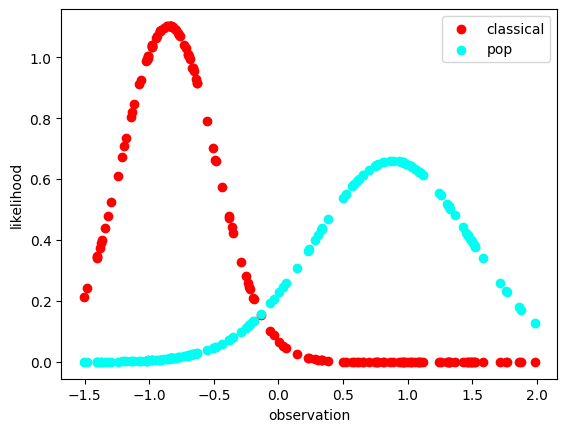

In [ ]:
#plot likelihood for spectral centroid mean
spectral_centroid_mean = calc_likelihood_for_plotting(pc_train)['spectral_centroid_mean']
plot_likelihood(spectral_centroid_mean)

<ipython-input-70-299d1f009a67>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", N+1)
<ipython-input-70-299d1f009a67>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,c = cmap(i))


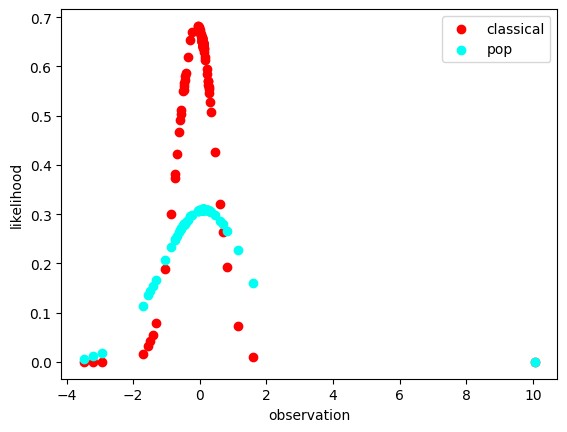

In [ ]:
#plot likelihood for harmony
harmony_mean = calc_likelihood_for_plotting(pc_train)['harmony_mean']
plot_likelihood(harmony_mean)

<ipython-input-70-299d1f009a67>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", N+1)
<ipython-input-70-299d1f009a67>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,c = cmap(i))


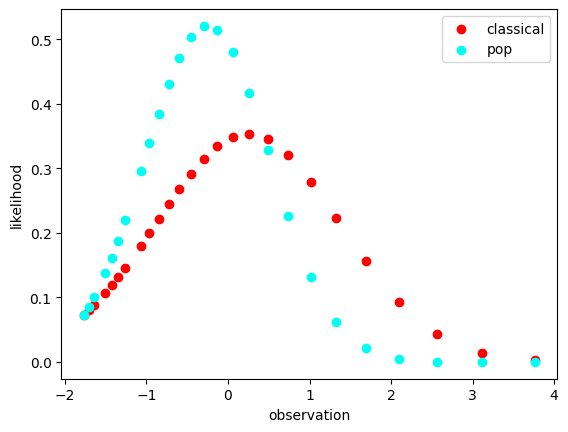

In [ ]:
#plot likelihood for tempo
tempo = calc_likelihood_for_plotting(pc_train)['tempo']
plot_likelihood(tempo)

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [ ]:
evaluate(gz_test, gz_train)

Accuracy: 0.495

Recall: 'macro:' 0.5065

F1 Score: 'macro:' 0.5018

Precision: 'macro:' 0.4777



array([[ 8,  0,  0,  0,  0,  1,  5,  0,  4,  1],
       [ 0, 17,  0,  0,  0,  1,  0,  0,  1,  1],
       [ 2,  0,  2,  2,  0,  2,  2,  2,  2,  2],
       [ 1,  0,  0, 10,  3,  1,  4,  0,  1,  2],
       [ 0,  0,  1,  5,  5,  0,  2,  3,  3,  2],
       [ 0,  0,  0,  0,  0, 10,  0,  1,  0,  7],
       [ 0,  0,  0,  1,  1,  0, 18,  0,  0,  0],
       [ 0,  0,  0,  2,  1,  2,  0, 16,  2,  0],
       [ 2,  0,  1,  0,  0,  0,  0,  0, 10,  1],
       [ 7,  1,  0,  5,  1,  1,  8,  0,  1,  3]])

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

In [ ]:
#code inspired from workshop in COMP30027
#implement 0R baseline
zero_r = DummyClassifier(strategy='most_frequent')
#features of the dataset
X = gz_train.iloc[:, 1:-1]
#labels of the dataset
y = gz_train.iloc[:,-1]
zero_r.fit(X, y)
zr_pred = zero_r.predict(X)
zero_r_acc = zero_r.score(X, y)
print(f"0R Accuracy: {round(zero_r_acc, 4)}\n")

0R Accuracy: 0.1075



In [ ]:
#code inspired from workshop in COMP30027
#implement 1R baseline
one_r = DecisionTreeClassifier(max_depth=1)
X = gz_train.iloc[:, 1:-1]
y = gz_train.iloc[:,-1]
one_r.fit(X, y)
one_r_acc = one_r.score(X, y)
print(f"1R Accuracy: {round(one_r_acc, 4)}\n")

#implement decision tree
dt = DecisionTreeClassifier(max_depth=None)
dt.fit(X, y)
dt_acc = dt.score(X, y)
print(f"Decision Tree Accuracy: {round(dt_acc, 4)}\n")

#get the feature name for best predictor feature
importances = one_r.feature_importances_
print(importances)

max_index = np.argmax(importances)
best_feature_name = numeric_columns(gz_train)[max_index]
print(f"Best Attribute for 1R baseline evaluation: {best_feature_name}\n")

1R Accuracy: 0.1962

Decision Tree Accuracy: 0.9988

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Attribute for 1R baseline evaluation: perceptr_var



### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

In [ ]:
#combine test and train dataset for gztan data
frames = [gz_train, gz_test]
gz_dataset = pd.concat(frames)
#features stored in X
X = gz_dataset.iloc[:,1:-1]
#labels stored in y
y = gz_dataset.iloc[:,-1]

In [ ]:
'''code inspired from workshop in COMP20008 semester 2022
'''
#run experiment by changing the size of train set
for train_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print('Running experiments with test set size: {}'.format(train_size))
    #divide train and test set according to test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_size)
    train_size_idx = int(train_size * len(X_train))
    X_train_subset = X_train[:train_size_idx]
    y_train_subset = y_train[:train_size_idx]
    #k-fold cross validation
    num_folds = 5
    kf = KFold(n_splits=num_folds)
    #empty list to store accuracy for each fold
    accuracy = []
    f1 = []
    recall = []
    precision = []
    for train_index, val_index in kf.split(X_train_subset):
        #divide train and test set according to k splits
        X_train_fold, X_val_fold = X_train_subset.iloc[train_index], X_train_subset.iloc[val_index]
        y_train_fold, y_val_fold = y_train_subset.iloc[train_index], y_train_subset.iloc[val_index]
        trainset = pd.concat([X_train_fold, y_train_fold], axis=1)
        #train the model        
        prior_prob, statistics = train(trainset)

        #get the prediction on test set
        prediction = predict(X_val_fold, prior_prob, statistics)
        true_label = y_val_fold.tolist()

        #check accuracy for each fold
        accuracy_val = accuracy_score(true_label, prediction)
        accuracy.append(accuracy_val)

        #check recall for each fold
        recall_val = recall_score(true_label, prediction, average = 'macro')
        recall.append(recall_val)

        #check f1 score for each fold
        f1_val = f1_score(true_label, prediction, average = 'macro')
        f1.append(f1_val)

        #check precision for each fold
        precision_val = precision_score(true_label, prediction, average = 'macro')
        precision.append(precision_val)

    #get average accuracy, recall, f1 score, precision for each test size    
    avg_acc = np.mean(accuracy)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    avg_precision = np.mean(precision)
    print(f'Average Accuracy: {round(avg_acc, 4)}\n')
    print(f'Average Recall: {round(avg_recall, 4)}\n')
    print(f'Average F1 Score: {round(avg_f1, 4)}\n')
    print(f'Average Precision: {round(avg_precision, 4)}\n')

Running experiments with test set size: 0.1


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-61-d9900ef0bfd7>:7: RuntimeWarning: divide by zero encountered in double_scalars
  exponent = math.exp(-((x - mean) ** 2 / (2 * std ** 2)))
<ipython-input-61-d9900ef0bfd7>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / (math.sqrt(2 * math.pi) * std)) * exponent
<ipython-input-61-d9900ef0bfd7>:8: RuntimeWarning: invalid value encountered in double_scalars
  return 

Average Accuracy: 0.3667

Average Recall: 0.3253

Average F1 Score: 0.2517

Average Precision: 0.2661

Running experiments with test set size: 0.2


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-d

Average Accuracy: 0.5375

Average Recall: 0.5031

Average F1 Score: 0.4714

Average Precision: 0.5094

Running experiments with test set size: 0.3
Average Accuracy: 0.5619

Average Recall: 0.556

Average F1 Score: 0.5338

Average Precision: 0.5645

Running experiments with test set size: 0.4


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.5292

Average Recall: 0.5046

Average F1 Score: 0.4832

Average Precision: 0.5302

Running experiments with test set size: 0.5
Average Accuracy: 0.516

Average Recall: 0.525

Average F1 Score: 0.4943

Average Precision: 0.5316

Running experiments with test set size: 0.6


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.4875

Average Recall: 0.491

Average F1 Score: 0.4695

Average Precision: 0.5088

Running experiments with test set size: 0.7
Average Accuracy: 0.5286

Average Recall: 0.5131

Average F1 Score: 0.4761

Average Precision: 0.5047

Running experiments with test set size: 0.8


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.5375

Average Recall: 0.5292

Average F1 Score: 0.492

Average Precision: 0.5149

Running experiments with test set size: 0.9


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-d

Average Accuracy: 0.3444

Average Recall: 0.2841

Average F1 Score: 0.2494

Average Precision: 0.2472



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [ ]:
def delete(data, decimal):  
    '''take input training dataset and probability of data to be deleted randomly
    return dataframe with missing data'''
    for col in numeric_columns(data):
        data.loc[data.sample(frac= decimal).index, col] = np.nan
    return data

In [ ]:
#run experiment by changing the probability of deletion and evaluate accuracy
for delete_data_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print('Running experiments with {}% missing features data\n'.format(delete_data_percentage*100))
    gz_train_data = delete(gz_train.copy(), delete_data_percentage)
    #print model evaluation specs for each deletion ratio
    evaluate(gz_test, gz_train_data)

Running experiments with 10.0% missing features data

Accuracy: 0.485

Recall: 'macro:' 0.4914

F1 Score: 'macro:' 0.4926

Precision: 'macro:' 0.4672

Running experiments with 20.0% missing features data

Accuracy: 0.51

Recall: 'macro:' 0.5213

F1 Score: 'macro:' 0.5067

Precision: 'macro:' 0.4934

Running experiments with 30.0% missing features data

Accuracy: 0.505

Recall: 'macro:' 0.5152

F1 Score: 'macro:' 0.5049

Precision: 'macro:' 0.4835

Running experiments with 40.0% missing features data

Accuracy: 0.495

Recall: 'macro:' 0.5063

F1 Score: 'macro:' 0.4923

Precision: 'macro:' 0.4826

Running experiments with 50.0% missing features data

Accuracy: 0.53

Recall: 'macro:' 0.5357

F1 Score: 'macro:' 0.5471

Precision: 'macro:' 0.5108

Running experiments with 60.0% missing features data

Accuracy: 0.515

Recall: 'macro:' 0.522

F1 Score: 'macro:' 0.5041

Precision: 'macro:' 0.4955

Running experiments with 70.0% missing features data

Accuracy: 0.555

Recall: 'macro:' 0.5683

F

<ipython-input-61-d9900ef0bfd7>:7: RuntimeWarning: divide by zero encountered in double_scalars
  exponent = math.exp(-((x - mean) ** 2 / (2 * std ** 2)))
<ipython-input-61-d9900ef0bfd7>:8: RuntimeWarning: divide by zero encountered in double_scalars
  return (1 / (math.sqrt(2 * math.pi) * std)) * exponent
<ipython-input-61-d9900ef0bfd7>:8: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / (math.sqrt(2 * math.pi) * std)) * exponent


Accuracy: 0.11

Recall: 'macro:' 0.1

F1 Score: 'macro:' 0.011

Precision: 'macro:' 0.0198



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
